# AST‐Powered Autoencoder for DCASE‑Inspired Anomalous Sound Detection


In [2]:
# Install dependencies (uncomment if needed)
!pip install timm==0.4.5

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os, glob, random, json
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import librosa, librosa.display
import numpy as np

In [4]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)


Using device: cuda


## AST Feature Extraction Demo Integration

In [5]:
from asts.src.models import ASTModel

# Define visualization subclass
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        nh = block.attn.num_heads
        scale = block.attn.scale
        B,N,C = x.shape
        qkv = qkv(x).reshape(B,N,3,nh,C//nh).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * scale
        return attn.softmax(dim=-1)
    def forward_visualization(self, x):
        x = x.unsqueeze(1).transpose(2,3)
        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls = self.v.cls_token.expand(B,-1,-1)
        dist= self.v.dist_token.expand(B,-1,-1)
        x = torch.cat((cls,dist,x),dim=1)+self.v.pos_embed
        attn_maps=[]
        for blk in self.v.blocks:
            att = self.get_att_map(blk,x)
            attn_maps.append(att)
            x = blk(x)
        return attn_maps

# Download pretrained AST weights
os.makedirs('ast_models', exist_ok=True)
ckpt=r'C:\Users\dell\Desktop\Projects\aml-main\aml-main\Challenge_2\asts\pretrained_models\audioset_10_10_0.4593.pth'

# Initialize AST model
model_ast = ASTModelVis(label_dim=527,input_tdim=1024,imagenet_pretrain=False,audioset_pretrain=False)
state = torch.load(ckpt,map_location=DEVICE)
model_ast = torch.nn.DataParallel(model_ast).to(DEVICE)
model_ast.load_state_dict(state)
model_ast.eval()


c:\Users\dell\Desktop\Projects\aml-main\aml-main\Challenge_2\asts\src\models\ast_models.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212


DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

## Data Preparation & AST CLS Embedding Extraction

In [6]:
TRAIN_DIR='DATA/dev_data/dev_data/slider/train'
TEST_DIR ='DATA/dev_data/dev_data/slider/test'
EMB_DIR ='DATA/embeddings_ast'
os.makedirs(f'{EMB_DIR}/train',exist_ok=True)
os.makedirs(f'{EMB_DIR}/test', exist_ok=True)

import torchaudio.functional as Ffunc
def make_feats(path):
    wav, sr = torchaudio.load(path)
    assert sr==16000,'Sampling rate must be 16kHz'
    fbank = torchaudio.compliance.kaldi.fbank(
        wav, htk_compat=True, sample_frequency=sr,
        use_energy=False, window_type='hanning',
        num_mel_bins=128, dither=0.0, frame_shift=10)
    # normalize with precomputed mean/std
    return (fbank - (-4.2677))/(4.5689*2)

for split,files in [('train',sorted(glob.glob(f'{TRAIN_DIR}/*.wav'))),
                    ('test', sorted(glob.glob(f'{TEST_DIR}/*.wav')))]:
    out_dir=os.path.join(EMB_DIR,split)
    for wav in tqdm(files,desc=f'AST Emb {split}',leave=False):
        name=os.path.basename(wav).replace('.wav','.npy')
        p=os.path.join(out_dir,name)
        if os.path.exists(p): continue
        feats=make_feats(wav)[None,:,:]
        with torch.no_grad():
            # forward_visualization to get attn, but we take cls token embedding
            # easier: use standard forward, get output before classifier
            x = feats.unsqueeze(1).transpose(2,3).to(DEVICE)
            B= x.shape[0]
            x = model_ast.module.v.patch_embed(x)
            cls = model_ast.module.v.cls_token.expand(B,-1,-1)
            x = torch.cat((cls, x), dim=1)
            if x.shape[1] != model_ast.module.v.pos_embed.shape[1]:
                pe = model_ast.module.v.pos_embed
                cls_token = pe[:, :1, :]
                pos_tokens = pe[:, 1:, :]

                # interpolate position tokens to match input length - 1
                new_len = x.shape[1] - 1
                pos_tokens_interp = torch.nn.functional.interpolate(
                    pos_tokens.permute(0, 2, 1), size=new_len, mode='linear', align_corners=False
                ).permute(0, 2, 1)

                x = x + torch.cat([cls_token, pos_tokens_interp], dim=1)
            else:
                x = x + model_ast.module.v.pos_embed

            # run through blocks
            for blk in model_ast.module.v.blocks:
                x = blk(x)
        emb = x[:,0].cpu().numpy()  # CLS embedding
        np.save(p, emb)


AST Emb train:   0%|          | 0/2370 [00:00<?, ?it/s]

## Dataset, Autoencoder & Training on AST Embeddings

In [18]:
# --- correct the Dataset to squeeze out any extra dims ---
class ASTDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])         # maybe shape (1,768) or (768,)
        arr = np.squeeze(arr)                  # now (768,)
        x   = torch.tensor(arr, dtype=torch.float32)
        y   = 0 if 'normal' in self.files[idx].lower() else 1
        return x, y

# --- correct the FC-UNet AE so all Linear layers get [B,features] inputs ---
class FCUnetAE(nn.Module):
    def __init__(self,
                 input_dim=768,
                 hidden_dims=(1024, 512),
                 latent_dim=128,
                 dropout=0.2):
        super().__init__()
        # Encoder
        enc_dims = [input_dim, *hidden_dims]
        self.enc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_d, out_d),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
            )
            for in_d, out_d in zip(enc_dims, enc_dims[1:])
        ])
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(hidden_dims[-1], latent_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, hidden_dims[-1]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        # Decoder with skip-connections
        skips = hidden_dims
        dec_dims_in  = [hidden_dims[-1] + h for h in reversed(skips)] + [hidden_dims[0]]
        dec_dims_out = list(reversed(skips)) + [input_dim]
        self.dec_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_d, out_d),
                nn.Identity() if out_d == input_dim else nn.ReLU(inplace=True),
            )
            for in_d, out_d in zip(dec_dims_in, dec_dims_out)
        ])

    def forward(self, x):
        # x: [B, 768]
        skips = []
        for enc in self.enc_layers:
            x = enc(x)
            skips.append(x)
        x = self.bottleneck(x)
        # decode, using skips in reverse
        for dec, skip in zip(self.dec_layers[:-1], reversed(skips)):
            x = torch.cat([x, skip], dim=1)  # -> [B, prev_dim+skip_dim]
            x = dec(x)
        x = self.dec_layers[-1](x)
        return x

# --- usage ---
train_ds = ASTDataset(f'{EMB_DIR}/train')
test_ds  = ASTDataset(f'{EMB_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=512)

model = FCUnetAE(input_dim=768, hidden_dims=(1024,512), latent_dim=128).to(DEVICE)
print(model)


FCUnetAE(
  (enc_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (bottleneck): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (dec_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1536, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1024, out_features

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500

# Scheduler + ear|ly-stop params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=10, 
)
patience = 20       # how many epochs to wait for loss improvement
min_delta = 1e-4    # minimum change in loss to count as “improved”

history = []
best_loss = float('inf')
stale_epochs = 0

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}', leave=False):
        x = x.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)

    avg = total_loss / len(train_ds)
    history.append(avg)
    print(f'Epoch {ep:2d} loss={avg:.6f}')

    # step the LR scheduler on the validation metric (here train loss)
    scheduler.step(avg)

    # early-stopping check
    if best_loss - avg > min_delta:
        best_loss = avg
        stale_epochs = 0
        print(f"  ↳ Improvement detected (new best_loss={best_loss:.6f}). Patience reset.")
    else:
        stale_epochs += 1
        print(f"  ↳ No significant improvement for {stale_epochs}/{patience} epochs.")
        if stale_epochs >= patience:
            print(f"Early stopping at epoch {ep}: no loss decrease >{min_delta} for {patience} epochs.")
            break


Epoch  1 loss=0.380294
  ↳ Improvement detected (new best_loss=0.380294). Patience reset.


Epoch  2 loss=0.245237
  ↳ Improvement detected (new best_loss=0.245237). Patience reset.


Epoch  3 loss=0.175879
  ↳ Improvement detected (new best_loss=0.175879). Patience reset.


Epoch  4 loss=0.149769
  ↳ Improvement detected (new best_loss=0.149769). Patience reset.


Epoch  5 loss=0.130506
  ↳ Improvement detected (new best_loss=0.130506). Patience reset.


Epoch  6 loss=0.115157
  ↳ Improvement detected (new best_loss=0.115157). Patience reset.


Epoch  7 loss=0.104323
  ↳ Improvement detected (new best_loss=0.104323). Patience reset.


Epoch  8 loss=0.095464
  ↳ Improvement detected (new best_loss=0.095464). Patience reset.


Epoch  9 loss=0.088973
  ↳ Improvement detected (new best_loss=0.088973). Patience reset.


Epoch 10 loss=0.083208
  ↳ Improvement detected (new best_loss=0.083208). Patience reset.


Epoch 11 loss=0.078524
  ↳ Improvement detected (new best_loss=0.078524). Patience reset.


Epoch 12 loss=0.074527
  ↳ Improvement detected (new best_loss=0.074527). Patience reset.


Epoch 13 loss=0.070897
  ↳ Improvement detected (new best_loss=0.070897). Patience reset.


Epoch 14 loss=0.067857
  ↳ Improvement detected (new best_loss=0.067857). Patience reset.


Epoch 15 loss=0.065165
  ↳ Improvement detected (new best_loss=0.065165). Patience reset.


Epoch 16 loss=0.062660
  ↳ Improvement detected (new best_loss=0.062660). Patience reset.


Epoch 17 loss=0.060511
  ↳ Improvement detected (new best_loss=0.060511). Patience reset.


Epoch 18 loss=0.058429
  ↳ Improvement detected (new best_loss=0.058429). Patience reset.


Epoch 19 loss=0.056653
  ↳ Improvement detected (new best_loss=0.056653). Patience reset.


Epoch 20 loss=0.054974
  ↳ Improvement detected (new best_loss=0.054974). Patience reset.


Epoch 21 loss=0.053475
  ↳ Improvement detected (new best_loss=0.053475). Patience reset.


Epoch 22 loss=0.052148
  ↳ Improvement detected (new best_loss=0.052148). Patience reset.


Epoch 23 loss=0.050835
  ↳ Improvement detected (new best_loss=0.050835). Patience reset.


Epoch 24 loss=0.049587
  ↳ Improvement detected (new best_loss=0.049587). Patience reset.


Epoch 25 loss=0.048434
  ↳ Improvement detected (new best_loss=0.048434). Patience reset.


Epoch 26 loss=0.047426
  ↳ Improvement detected (new best_loss=0.047426). Patience reset.


Epoch 27 loss=0.046350
  ↳ Improvement detected (new best_loss=0.046350). Patience reset.


Epoch 28 loss=0.045440
  ↳ Improvement detected (new best_loss=0.045440). Patience reset.


Epoch 29 loss=0.044475
  ↳ Improvement detected (new best_loss=0.044475). Patience reset.


Epoch 30 loss=0.043602
  ↳ Improvement detected (new best_loss=0.043602). Patience reset.


Epoch 31 loss=0.042767
  ↳ Improvement detected (new best_loss=0.042767). Patience reset.


Epoch 32 loss=0.041956
  ↳ Improvement detected (new best_loss=0.041956). Patience reset.


Epoch 33 loss=0.041345
  ↳ Improvement detected (new best_loss=0.041345). Patience reset.


Epoch 34 loss=0.040878
  ↳ Improvement detected (new best_loss=0.040878). Patience reset.


Epoch 35 loss=0.040309
  ↳ Improvement detected (new best_loss=0.040309). Patience reset.


Epoch 36 loss=0.039564
  ↳ Improvement detected (new best_loss=0.039564). Patience reset.


Epoch 37 loss=0.039115
  ↳ Improvement detected (new best_loss=0.039115). Patience reset.


Epoch 38 loss=0.038456
  ↳ Improvement detected (new best_loss=0.038456). Patience reset.


Epoch 39 loss=0.037889
  ↳ Improvement detected (new best_loss=0.037889). Patience reset.


Epoch 40 loss=0.037455
  ↳ Improvement detected (new best_loss=0.037455). Patience reset.


Epoch 41 loss=0.037017
  ↳ Improvement detected (new best_loss=0.037017). Patience reset.


Epoch 42 loss=0.036599
  ↳ Improvement detected (new best_loss=0.036599). Patience reset.


Epoch 43 loss=0.036165
  ↳ Improvement detected (new best_loss=0.036165). Patience reset.


Epoch 44 loss=0.035637
  ↳ Improvement detected (new best_loss=0.035637). Patience reset.


Epoch 45 loss=0.035251
  ↳ Improvement detected (new best_loss=0.035251). Patience reset.


Epoch 46 loss=0.034973
  ↳ Improvement detected (new best_loss=0.034973). Patience reset.


Epoch 47 loss=0.034543
  ↳ Improvement detected (new best_loss=0.034543). Patience reset.


Epoch 48 loss=0.033941
  ↳ Improvement detected (new best_loss=0.033941). Patience reset.


Epoch 49 loss=0.033744
  ↳ Improvement detected (new best_loss=0.033744). Patience reset.


Epoch 50 loss=0.033478
  ↳ Improvement detected (new best_loss=0.033478). Patience reset.


Epoch 51 loss=0.033093
  ↳ Improvement detected (new best_loss=0.033093). Patience reset.


Epoch 52 loss=0.032769
  ↳ Improvement detected (new best_loss=0.032769). Patience reset.


Epoch 53 loss=0.032551
  ↳ Improvement detected (new best_loss=0.032551). Patience reset.


Epoch 54 loss=0.032182
  ↳ Improvement detected (new best_loss=0.032182). Patience reset.


Epoch 55 loss=0.031883
  ↳ Improvement detected (new best_loss=0.031883). Patience reset.


Epoch 56 loss=0.031609
  ↳ Improvement detected (new best_loss=0.031609). Patience reset.


Epoch 57 loss=0.031324
  ↳ Improvement detected (new best_loss=0.031324). Patience reset.


Epoch 58 loss=0.031243
  ↳ No significant improvement for 1/20 epochs.


Epoch 59 loss=0.031004
  ↳ Improvement detected (new best_loss=0.031004). Patience reset.


Epoch 60 loss=0.030754
  ↳ Improvement detected (new best_loss=0.030754). Patience reset.


Epoch 61 loss=0.030448
  ↳ Improvement detected (new best_loss=0.030448). Patience reset.


Epoch 62 loss=0.030199
  ↳ Improvement detected (new best_loss=0.030199). Patience reset.


Epoch 63 loss=0.029919
  ↳ Improvement detected (new best_loss=0.029919). Patience reset.


Epoch 64 loss=0.029674
  ↳ Improvement detected (new best_loss=0.029674). Patience reset.


Epoch 65 loss=0.029530
  ↳ Improvement detected (new best_loss=0.029530). Patience reset.


Epoch 66 loss=0.029425
  ↳ Improvement detected (new best_loss=0.029425). Patience reset.


Epoch 67 loss=0.028976
  ↳ Improvement detected (new best_loss=0.028976). Patience reset.


Epoch 68 loss=0.028791
  ↳ Improvement detected (new best_loss=0.028791). Patience reset.


Epoch 69 loss=0.028615
  ↳ Improvement detected (new best_loss=0.028615). Patience reset.


Epoch 70 loss=0.028329
  ↳ Improvement detected (new best_loss=0.028329). Patience reset.


Epoch 71 loss=0.028283
  ↳ No significant improvement for 1/20 epochs.


Epoch 72 loss=0.028102
  ↳ Improvement detected (new best_loss=0.028102). Patience reset.


Epoch 73 loss=0.027948
  ↳ Improvement detected (new best_loss=0.027948). Patience reset.


Epoch 74 loss=0.027677
  ↳ Improvement detected (new best_loss=0.027677). Patience reset.


Epoch 75 loss=0.027536
  ↳ Improvement detected (new best_loss=0.027536). Patience reset.


Epoch 76 loss=0.027324
  ↳ Improvement detected (new best_loss=0.027324). Patience reset.


Epoch 77 loss=0.027204
  ↳ Improvement detected (new best_loss=0.027204). Patience reset.


Epoch 78 loss=0.027123
  ↳ No significant improvement for 1/20 epochs.


Epoch 79 loss=0.026924
  ↳ Improvement detected (new best_loss=0.026924). Patience reset.


Epoch 80 loss=0.026901
  ↳ No significant improvement for 1/20 epochs.


Epoch 81 loss=0.026928
  ↳ No significant improvement for 2/20 epochs.


Epoch 82 loss=0.026697
  ↳ Improvement detected (new best_loss=0.026697). Patience reset.


Epoch 83 loss=0.026523
  ↳ Improvement detected (new best_loss=0.026523). Patience reset.


Epoch 84 loss=0.026216
  ↳ Improvement detected (new best_loss=0.026216). Patience reset.


Epoch 85 loss=0.026142
  ↳ No significant improvement for 1/20 epochs.


Epoch 86 loss=0.026018
  ↳ Improvement detected (new best_loss=0.026018). Patience reset.


Epoch 87 loss=0.025722
  ↳ Improvement detected (new best_loss=0.025722). Patience reset.


Epoch 88 loss=0.025814
  ↳ No significant improvement for 1/20 epochs.


Epoch 89 loss=0.025604
  ↳ Improvement detected (new best_loss=0.025604). Patience reset.


Epoch 90 loss=0.025424
  ↳ Improvement detected (new best_loss=0.025424). Patience reset.


Epoch 91 loss=0.025428
  ↳ No significant improvement for 1/20 epochs.


Epoch 92 loss=0.025204
  ↳ Improvement detected (new best_loss=0.025204). Patience reset.


Epoch 93 loss=0.025046
  ↳ Improvement detected (new best_loss=0.025046). Patience reset.


Epoch 94 loss=0.024930
  ↳ Improvement detected (new best_loss=0.024930). Patience reset.


Epoch 95 loss=0.024856
  ↳ No significant improvement for 1/20 epochs.


Epoch 96 loss=0.024720
  ↳ Improvement detected (new best_loss=0.024720). Patience reset.


Epoch 97 loss=0.024525
  ↳ Improvement detected (new best_loss=0.024525). Patience reset.


Epoch 98 loss=0.024427
  ↳ No significant improvement for 1/20 epochs.


Epoch 99 loss=0.024361
  ↳ Improvement detected (new best_loss=0.024361). Patience reset.


Epoch 100 loss=0.024227
  ↳ Improvement detected (new best_loss=0.024227). Patience reset.


Epoch 101 loss=0.024096
  ↳ Improvement detected (new best_loss=0.024096). Patience reset.


Epoch 102 loss=0.024002
  ↳ No significant improvement for 1/20 epochs.


Epoch 103 loss=0.023861
  ↳ Improvement detected (new best_loss=0.023861). Patience reset.


Epoch 104 loss=0.023775
  ↳ No significant improvement for 1/20 epochs.


Epoch 105 loss=0.023719
  ↳ Improvement detected (new best_loss=0.023719). Patience reset.


Epoch 106 loss=0.023529
  ↳ Improvement detected (new best_loss=0.023529). Patience reset.


Epoch 107 loss=0.023436
  ↳ No significant improvement for 1/20 epochs.


Epoch 108 loss=0.023452
  ↳ No significant improvement for 2/20 epochs.


Epoch 109 loss=0.023362
  ↳ Improvement detected (new best_loss=0.023362). Patience reset.


Epoch 110 loss=0.023391
  ↳ No significant improvement for 1/20 epochs.


Epoch 111 loss=0.023222
  ↳ Improvement detected (new best_loss=0.023222). Patience reset.


Epoch 112 loss=0.023192
  ↳ No significant improvement for 1/20 epochs.


Epoch 113 loss=0.023031
  ↳ Improvement detected (new best_loss=0.023031). Patience reset.


Epoch 114 loss=0.022791
  ↳ Improvement detected (new best_loss=0.022791). Patience reset.


Epoch 115 loss=0.022605
  ↳ Improvement detected (new best_loss=0.022605). Patience reset.


Epoch 116 loss=0.022636
  ↳ No significant improvement for 1/20 epochs.


Epoch 117 loss=0.022528
  ↳ No significant improvement for 2/20 epochs.


Epoch 118 loss=0.022417
  ↳ Improvement detected (new best_loss=0.022417). Patience reset.


Epoch 119 loss=0.022472
  ↳ No significant improvement for 1/20 epochs.


Epoch 120 loss=0.022533
  ↳ No significant improvement for 2/20 epochs.


Epoch 121 loss=0.022364
  ↳ No significant improvement for 3/20 epochs.


Epoch 122 loss=0.022276
  ↳ Improvement detected (new best_loss=0.022276). Patience reset.


Epoch 123 loss=0.022220
  ↳ No significant improvement for 1/20 epochs.


Epoch 124 loss=0.022099
  ↳ Improvement detected (new best_loss=0.022099). Patience reset.


Epoch 125 loss=0.021954
  ↳ Improvement detected (new best_loss=0.021954). Patience reset.


Epoch 126 loss=0.021794
  ↳ Improvement detected (new best_loss=0.021794). Patience reset.


Epoch 127 loss=0.021810
  ↳ No significant improvement for 1/20 epochs.


Epoch 128 loss=0.021685
  ↳ Improvement detected (new best_loss=0.021685). Patience reset.


Epoch 129 loss=0.021589
  ↳ No significant improvement for 1/20 epochs.


Epoch 130 loss=0.021476
  ↳ Improvement detected (new best_loss=0.021476). Patience reset.


Epoch 131 loss=0.021367
  ↳ Improvement detected (new best_loss=0.021367). Patience reset.


Epoch 132 loss=0.021402
  ↳ No significant improvement for 1/20 epochs.


Epoch 133 loss=0.021290
  ↳ No significant improvement for 2/20 epochs.


Epoch 134 loss=0.021294
  ↳ No significant improvement for 3/20 epochs.


Epoch 135 loss=0.021082
  ↳ Improvement detected (new best_loss=0.021082). Patience reset.


Epoch 136 loss=0.021195
  ↳ No significant improvement for 1/20 epochs.


Epoch 137 loss=0.020974
  ↳ Improvement detected (new best_loss=0.020974). Patience reset.


Epoch 138 loss=0.021001
  ↳ No significant improvement for 1/20 epochs.


Epoch 139 loss=0.020899
  ↳ No significant improvement for 2/20 epochs.


Epoch 140 loss=0.020773
  ↳ Improvement detected (new best_loss=0.020773). Patience reset.


Epoch 141 loss=0.020713
  ↳ No significant improvement for 1/20 epochs.


Epoch 142 loss=0.020651
  ↳ Improvement detected (new best_loss=0.020651). Patience reset.


Epoch 143 loss=0.020599
  ↳ No significant improvement for 1/20 epochs.


Epoch 144 loss=0.020537
  ↳ Improvement detected (new best_loss=0.020537). Patience reset.


Epoch 145 loss=0.020528
  ↳ No significant improvement for 1/20 epochs.


Epoch 146 loss=0.020390
  ↳ Improvement detected (new best_loss=0.020390). Patience reset.


Epoch 147 loss=0.020317
  ↳ No significant improvement for 1/20 epochs.


Epoch 148 loss=0.020295
  ↳ No significant improvement for 2/20 epochs.


Epoch 149 loss=0.020335
  ↳ No significant improvement for 3/20 epochs.


Epoch 150 loss=0.020089
  ↳ Improvement detected (new best_loss=0.020089). Patience reset.


Epoch 151 loss=0.020024
  ↳ No significant improvement for 1/20 epochs.


Epoch 152 loss=0.019919
  ↳ Improvement detected (new best_loss=0.019919). Patience reset.


Epoch 153 loss=0.019895
  ↳ No significant improvement for 1/20 epochs.


Epoch 154 loss=0.019813
  ↳ Improvement detected (new best_loss=0.019813). Patience reset.


Epoch 155 loss=0.020028
  ↳ No significant improvement for 1/20 epochs.


Epoch 156 loss=0.019799
  ↳ No significant improvement for 2/20 epochs.


Epoch 157 loss=0.019711
  ↳ Improvement detected (new best_loss=0.019711). Patience reset.


Epoch 158 loss=0.019605
  ↳ Improvement detected (new best_loss=0.019605). Patience reset.


Epoch 159 loss=0.019583
  ↳ No significant improvement for 1/20 epochs.


Epoch 160 loss=0.019422
  ↳ Improvement detected (new best_loss=0.019422). Patience reset.


Epoch 161 loss=0.019387
  ↳ No significant improvement for 1/20 epochs.


Epoch 162 loss=0.019485
  ↳ No significant improvement for 2/20 epochs.


Epoch 163 loss=0.019376
  ↳ No significant improvement for 3/20 epochs.


Epoch 164 loss=0.019612
  ↳ No significant improvement for 4/20 epochs.


Epoch 165 loss=0.019486
  ↳ No significant improvement for 5/20 epochs.


Epoch 166 loss=0.019312
  ↳ Improvement detected (new best_loss=0.019312). Patience reset.


Epoch 167 loss=0.019304
  ↳ No significant improvement for 1/20 epochs.


Epoch 168 loss=0.019191
  ↳ Improvement detected (new best_loss=0.019191). Patience reset.


Epoch 169 loss=0.019117
  ↳ No significant improvement for 1/20 epochs.


Epoch 170 loss=0.019035
  ↳ Improvement detected (new best_loss=0.019035). Patience reset.


Epoch 171 loss=0.019062
  ↳ No significant improvement for 1/20 epochs.


Epoch 172 loss=0.018947
  ↳ No significant improvement for 2/20 epochs.


Epoch 173 loss=0.018926
  ↳ Improvement detected (new best_loss=0.018926). Patience reset.


Epoch 174 loss=0.018986
  ↳ No significant improvement for 1/20 epochs.


Epoch 175 loss=0.018891
  ↳ No significant improvement for 2/20 epochs.


Epoch 176 loss=0.018775
  ↳ Improvement detected (new best_loss=0.018775). Patience reset.


Epoch 177 loss=0.018693
  ↳ No significant improvement for 1/20 epochs.


Epoch 178 loss=0.018752
  ↳ No significant improvement for 2/20 epochs.


Epoch 179 loss=0.018648
  ↳ Improvement detected (new best_loss=0.018648). Patience reset.


Epoch 180 loss=0.018694
  ↳ No significant improvement for 1/20 epochs.


Epoch 181 loss=0.018592
  ↳ No significant improvement for 2/20 epochs.


Epoch 182 loss=0.018516
  ↳ Improvement detected (new best_loss=0.018516). Patience reset.


Epoch 183 loss=0.018449
  ↳ No significant improvement for 1/20 epochs.


Epoch 184 loss=0.018445
  ↳ No significant improvement for 2/20 epochs.


Epoch 185 loss=0.018322
  ↳ Improvement detected (new best_loss=0.018322). Patience reset.


Epoch 186 loss=0.018263
  ↳ No significant improvement for 1/20 epochs.


Epoch 187 loss=0.018290
  ↳ No significant improvement for 2/20 epochs.


Epoch 188 loss=0.018135
  ↳ Improvement detected (new best_loss=0.018135). Patience reset.


Epoch 189 loss=0.018140
  ↳ No significant improvement for 1/20 epochs.


Epoch 190 loss=0.018152
  ↳ No significant improvement for 2/20 epochs.


Epoch 191 loss=0.017991
  ↳ Improvement detected (new best_loss=0.017991). Patience reset.


Epoch 192 loss=0.018012
  ↳ No significant improvement for 1/20 epochs.


Epoch 193 loss=0.017984
  ↳ No significant improvement for 2/20 epochs.


Epoch 194 loss=0.018049
  ↳ No significant improvement for 3/20 epochs.


Epoch 195 loss=0.018034
  ↳ No significant improvement for 4/20 epochs.


Epoch 196 loss=0.017874
  ↳ Improvement detected (new best_loss=0.017874). Patience reset.


Epoch 197 loss=0.017769
  ↳ Improvement detected (new best_loss=0.017769). Patience reset.


Epoch 198 loss=0.017809
  ↳ No significant improvement for 1/20 epochs.


Epoch 199 loss=0.017747
  ↳ No significant improvement for 2/20 epochs.


Epoch 200 loss=0.017706
  ↳ No significant improvement for 3/20 epochs.


Epoch 201 loss=0.017619
  ↳ Improvement detected (new best_loss=0.017619). Patience reset.


Epoch 202 loss=0.017583
  ↳ No significant improvement for 1/20 epochs.


Epoch 203 loss=0.017598
  ↳ No significant improvement for 2/20 epochs.


Epoch 204 loss=0.017667
  ↳ No significant improvement for 3/20 epochs.


Epoch 205 loss=0.017515
  ↳ Improvement detected (new best_loss=0.017515). Patience reset.


Epoch 206 loss=0.017629
  ↳ No significant improvement for 1/20 epochs.


Epoch 207 loss=0.017434
  ↳ No significant improvement for 2/20 epochs.


Epoch 208 loss=0.017554
  ↳ No significant improvement for 3/20 epochs.


Epoch 209 loss=0.017442
  ↳ No significant improvement for 4/20 epochs.


Epoch 210 loss=0.017388
  ↳ Improvement detected (new best_loss=0.017388). Patience reset.


Epoch 211 loss=0.017373
  ↳ No significant improvement for 1/20 epochs.


Epoch 212 loss=0.017319
  ↳ No significant improvement for 2/20 epochs.


Epoch 213 loss=0.017251
  ↳ Improvement detected (new best_loss=0.017251). Patience reset.


Epoch 214 loss=0.017229
  ↳ No significant improvement for 1/20 epochs.


Epoch 215 loss=0.017170
  ↳ No significant improvement for 2/20 epochs.


Epoch 216 loss=0.017088
  ↳ Improvement detected (new best_loss=0.017088). Patience reset.


Epoch 217 loss=0.017019
  ↳ No significant improvement for 1/20 epochs.


Epoch 218 loss=0.016950
  ↳ Improvement detected (new best_loss=0.016950). Patience reset.


Epoch 219 loss=0.017038
  ↳ No significant improvement for 1/20 epochs.


Epoch 220 loss=0.016995
  ↳ No significant improvement for 2/20 epochs.


Epoch 221 loss=0.016947
  ↳ No significant improvement for 3/20 epochs.


Epoch 222 loss=0.016976
  ↳ No significant improvement for 4/20 epochs.


Epoch 223 loss=0.016933
  ↳ No significant improvement for 5/20 epochs.


Epoch 224 loss=0.016914
  ↳ No significant improvement for 6/20 epochs.


Epoch 225 loss=0.016920
  ↳ No significant improvement for 7/20 epochs.


Epoch 226 loss=0.016950
  ↳ No significant improvement for 8/20 epochs.


Epoch 227 loss=0.016917
  ↳ No significant improvement for 9/20 epochs.


Epoch 228 loss=0.016925
  ↳ No significant improvement for 10/20 epochs.


Epoch 229 loss=0.016798
  ↳ Improvement detected (new best_loss=0.016798). Patience reset.


Epoch 230 loss=0.016665
  ↳ Improvement detected (new best_loss=0.016665). Patience reset.


Epoch 231 loss=0.016744
  ↳ No significant improvement for 1/20 epochs.


Epoch 232 loss=0.016545
  ↳ Improvement detected (new best_loss=0.016545). Patience reset.


Epoch 233 loss=0.016554
  ↳ No significant improvement for 1/20 epochs.


Epoch 234 loss=0.016586
  ↳ No significant improvement for 2/20 epochs.


Epoch 235 loss=0.016476
  ↳ No significant improvement for 3/20 epochs.


Epoch 236 loss=0.016532
  ↳ No significant improvement for 4/20 epochs.


Epoch 237 loss=0.016443
  ↳ Improvement detected (new best_loss=0.016443). Patience reset.


Epoch 238 loss=0.016433
  ↳ No significant improvement for 1/20 epochs.


Epoch 239 loss=0.016453
  ↳ No significant improvement for 2/20 epochs.


Epoch 240 loss=0.016377
  ↳ No significant improvement for 3/20 epochs.


Epoch 241 loss=0.016276
  ↳ Improvement detected (new best_loss=0.016276). Patience reset.


Epoch 242 loss=0.016261
  ↳ No significant improvement for 1/20 epochs.


Epoch 243 loss=0.016377
  ↳ No significant improvement for 2/20 epochs.


Epoch 244 loss=0.016257
  ↳ No significant improvement for 3/20 epochs.


Epoch 245 loss=0.016288
  ↳ No significant improvement for 4/20 epochs.


Epoch 246 loss=0.016178
  ↳ No significant improvement for 5/20 epochs.


Epoch 247 loss=0.016150
  ↳ Improvement detected (new best_loss=0.016150). Patience reset.


Epoch 248 loss=0.016059
  ↳ No significant improvement for 1/20 epochs.


Epoch 249 loss=0.016139
  ↳ No significant improvement for 2/20 epochs.


Epoch 250 loss=0.016033
  ↳ Improvement detected (new best_loss=0.016033). Patience reset.


Epoch 251 loss=0.015983
  ↳ No significant improvement for 1/20 epochs.


Epoch 252 loss=0.016013
  ↳ No significant improvement for 2/20 epochs.


Epoch 253 loss=0.015913
  ↳ Improvement detected (new best_loss=0.015913). Patience reset.


Epoch 254 loss=0.016033
  ↳ No significant improvement for 1/20 epochs.


Epoch 255 loss=0.015943
  ↳ No significant improvement for 2/20 epochs.


Epoch 256 loss=0.015935
  ↳ No significant improvement for 3/20 epochs.


Epoch 257 loss=0.016017
  ↳ No significant improvement for 4/20 epochs.


Epoch 258 loss=0.015965
  ↳ No significant improvement for 5/20 epochs.


Epoch 259 loss=0.015804
  ↳ Improvement detected (new best_loss=0.015804). Patience reset.


Epoch 260 loss=0.015898
  ↳ No significant improvement for 1/20 epochs.


Epoch 261 loss=0.015938
  ↳ No significant improvement for 2/20 epochs.


Epoch 262 loss=0.015872
  ↳ No significant improvement for 3/20 epochs.


Epoch 263 loss=0.015817
  ↳ No significant improvement for 4/20 epochs.


Epoch 264 loss=0.015819
  ↳ No significant improvement for 5/20 epochs.


Epoch 265 loss=0.015723
  ↳ No significant improvement for 6/20 epochs.


Epoch 266 loss=0.015613
  ↳ Improvement detected (new best_loss=0.015613). Patience reset.


Epoch 267 loss=0.015630
  ↳ No significant improvement for 1/20 epochs.


Epoch 268 loss=0.015485
  ↳ Improvement detected (new best_loss=0.015485). Patience reset.


Epoch 269 loss=0.015613
  ↳ No significant improvement for 1/20 epochs.


Epoch 270 loss=0.015543
  ↳ No significant improvement for 2/20 epochs.


Epoch 271 loss=0.015482
  ↳ No significant improvement for 3/20 epochs.


Epoch 272 loss=0.015481
  ↳ No significant improvement for 4/20 epochs.


Epoch 273 loss=0.015427
  ↳ No significant improvement for 5/20 epochs.


Epoch 274 loss=0.015478
  ↳ No significant improvement for 6/20 epochs.


Epoch 275 loss=0.015434
  ↳ No significant improvement for 7/20 epochs.


Epoch 276 loss=0.015452
  ↳ No significant improvement for 8/20 epochs.


Epoch 277 loss=0.015277
  ↳ Improvement detected (new best_loss=0.015277). Patience reset.


Epoch 278 loss=0.015335
  ↳ No significant improvement for 1/20 epochs.


Epoch 279 loss=0.015347
  ↳ No significant improvement for 2/20 epochs.


Epoch 280 loss=0.015336
  ↳ No significant improvement for 3/20 epochs.


Epoch 281 loss=0.015248
  ↳ No significant improvement for 4/20 epochs.


Epoch 282 loss=0.015221
  ↳ No significant improvement for 5/20 epochs.


Epoch 283 loss=0.015223
  ↳ No significant improvement for 6/20 epochs.


Epoch 284 loss=0.015139
  ↳ Improvement detected (new best_loss=0.015139). Patience reset.


Epoch 285 loss=0.015142
  ↳ No significant improvement for 1/20 epochs.


Epoch 286 loss=0.015145
  ↳ No significant improvement for 2/20 epochs.


Epoch 287 loss=0.015088
  ↳ No significant improvement for 3/20 epochs.


Epoch 288 loss=0.015159
  ↳ No significant improvement for 4/20 epochs.


Epoch 289 loss=0.015081
  ↳ No significant improvement for 5/20 epochs.


Epoch 290 loss=0.015106
  ↳ No significant improvement for 6/20 epochs.


Epoch 291 loss=0.015030
  ↳ Improvement detected (new best_loss=0.015030). Patience reset.


Epoch 292 loss=0.015040
  ↳ No significant improvement for 1/20 epochs.


Epoch 293 loss=0.015036
  ↳ No significant improvement for 2/20 epochs.


Epoch 294 loss=0.014990
  ↳ No significant improvement for 3/20 epochs.


Epoch 295 loss=0.015020
  ↳ No significant improvement for 4/20 epochs.


Epoch 296 loss=0.014908
  ↳ Improvement detected (new best_loss=0.014908). Patience reset.


Epoch 297 loss=0.014867
  ↳ No significant improvement for 1/20 epochs.


Epoch 298 loss=0.014861
  ↳ No significant improvement for 2/20 epochs.


Epoch 299 loss=0.014939
  ↳ No significant improvement for 3/20 epochs.


Epoch 300 loss=0.014804
  ↳ Improvement detected (new best_loss=0.014804). Patience reset.


Epoch 301 loss=0.014870
  ↳ No significant improvement for 1/20 epochs.


Epoch 302 loss=0.014826
  ↳ No significant improvement for 2/20 epochs.


Epoch 303 loss=0.014939
  ↳ No significant improvement for 3/20 epochs.


Epoch 304 loss=0.014808
  ↳ No significant improvement for 4/20 epochs.


Epoch 305 loss=0.014821
  ↳ No significant improvement for 5/20 epochs.


Epoch 306 loss=0.014708
  ↳ No significant improvement for 6/20 epochs.


Epoch 307 loss=0.014882
  ↳ No significant improvement for 7/20 epochs.


Epoch 308 loss=0.014701
  ↳ Improvement detected (new best_loss=0.014701). Patience reset.


Epoch 309 loss=0.014703
  ↳ No significant improvement for 1/20 epochs.


Epoch 310 loss=0.014707
  ↳ No significant improvement for 2/20 epochs.


Epoch 311 loss=0.014632
  ↳ No significant improvement for 3/20 epochs.


Epoch 312 loss=0.014622
  ↳ No significant improvement for 4/20 epochs.


Epoch 313 loss=0.014581
  ↳ Improvement detected (new best_loss=0.014581). Patience reset.


Epoch 314 loss=0.014532
  ↳ No significant improvement for 1/20 epochs.


Epoch 315 loss=0.014488
  ↳ No significant improvement for 2/20 epochs.


Epoch 316 loss=0.014431
  ↳ Improvement detected (new best_loss=0.014431). Patience reset.


Epoch 317 loss=0.014472
  ↳ No significant improvement for 1/20 epochs.


Epoch 318 loss=0.014427
  ↳ No significant improvement for 2/20 epochs.


Epoch 319 loss=0.014442
  ↳ No significant improvement for 3/20 epochs.


Epoch 320 loss=0.014429
  ↳ No significant improvement for 4/20 epochs.


Epoch 321 loss=0.014380
  ↳ No significant improvement for 5/20 epochs.


Epoch 322 loss=0.014347
  ↳ No significant improvement for 6/20 epochs.


Epoch 323 loss=0.014456
  ↳ No significant improvement for 7/20 epochs.


Epoch 324 loss=0.014449
  ↳ No significant improvement for 8/20 epochs.


Epoch 325 loss=0.014395
  ↳ No significant improvement for 9/20 epochs.


Epoch 326 loss=0.014358
  ↳ No significant improvement for 10/20 epochs.


Epoch 327 loss=0.014329
  ↳ Improvement detected (new best_loss=0.014329). Patience reset.


Epoch 328 loss=0.014349
  ↳ No significant improvement for 1/20 epochs.


Epoch 329 loss=0.014186
  ↳ Improvement detected (new best_loss=0.014186). Patience reset.


Epoch 330 loss=0.014274
  ↳ No significant improvement for 1/20 epochs.


Epoch 331 loss=0.014147
  ↳ No significant improvement for 2/20 epochs.


Epoch 332 loss=0.014102
  ↳ No significant improvement for 3/20 epochs.


Epoch 333 loss=0.014159
  ↳ No significant improvement for 4/20 epochs.


Epoch 334 loss=0.014068
  ↳ Improvement detected (new best_loss=0.014068). Patience reset.


Epoch 335 loss=0.014149
  ↳ No significant improvement for 1/20 epochs.


Epoch 336 loss=0.014119
  ↳ No significant improvement for 2/20 epochs.


Epoch 337 loss=0.014097
  ↳ No significant improvement for 3/20 epochs.


Epoch 338 loss=0.014150
  ↳ No significant improvement for 4/20 epochs.


Epoch 339 loss=0.014060
  ↳ No significant improvement for 5/20 epochs.


Epoch 340 loss=0.014022
  ↳ No significant improvement for 6/20 epochs.


Epoch 341 loss=0.013969
  ↳ No significant improvement for 7/20 epochs.


Epoch 342 loss=0.014014
  ↳ No significant improvement for 8/20 epochs.


Epoch 343 loss=0.013947
  ↳ Improvement detected (new best_loss=0.013947). Patience reset.


Epoch 344 loss=0.013980
  ↳ No significant improvement for 1/20 epochs.


Epoch 345 loss=0.013981
  ↳ No significant improvement for 2/20 epochs.


Epoch 346 loss=0.013981
  ↳ No significant improvement for 3/20 epochs.


Epoch 347 loss=0.014026
  ↳ No significant improvement for 4/20 epochs.


Epoch 348 loss=0.014061
  ↳ No significant improvement for 5/20 epochs.


Epoch 349 loss=0.013928
  ↳ No significant improvement for 6/20 epochs.


Epoch 350 loss=0.013814
  ↳ Improvement detected (new best_loss=0.013814). Patience reset.


Epoch 351 loss=0.013766
  ↳ No significant improvement for 1/20 epochs.


Epoch 352 loss=0.013794
  ↳ No significant improvement for 2/20 epochs.


Epoch 353 loss=0.013768
  ↳ No significant improvement for 3/20 epochs.


Epoch 354 loss=0.013823
  ↳ No significant improvement for 4/20 epochs.


Epoch 355 loss=0.013826
  ↳ No significant improvement for 5/20 epochs.


Epoch 356 loss=0.013745
  ↳ No significant improvement for 6/20 epochs.


Epoch 357 loss=0.013691
  ↳ Improvement detected (new best_loss=0.013691). Patience reset.


Epoch 358 loss=0.013864
  ↳ No significant improvement for 1/20 epochs.


Epoch 359 loss=0.013830
  ↳ No significant improvement for 2/20 epochs.


Epoch 360 loss=0.013747
  ↳ No significant improvement for 3/20 epochs.


Epoch 361 loss=0.013687
  ↳ No significant improvement for 4/20 epochs.


Epoch 362 loss=0.013723
  ↳ No significant improvement for 5/20 epochs.


Epoch 363 loss=0.013645
  ↳ No significant improvement for 6/20 epochs.


Epoch 364 loss=0.013647
  ↳ No significant improvement for 7/20 epochs.


Epoch 365 loss=0.013598
  ↳ No significant improvement for 8/20 epochs.


Epoch 366 loss=0.013670
  ↳ No significant improvement for 9/20 epochs.


Epoch 367 loss=0.013576
  ↳ Improvement detected (new best_loss=0.013576). Patience reset.


Epoch 368 loss=0.013530
  ↳ No significant improvement for 1/20 epochs.


Epoch 369 loss=0.013429
  ↳ Improvement detected (new best_loss=0.013429). Patience reset.


Epoch 370 loss=0.013496
  ↳ No significant improvement for 1/20 epochs.


Epoch 371 loss=0.013415
  ↳ No significant improvement for 2/20 epochs.


Epoch 372 loss=0.013463
  ↳ No significant improvement for 3/20 epochs.


Epoch 373 loss=0.013397
  ↳ No significant improvement for 4/20 epochs.


Epoch 374 loss=0.013432
  ↳ No significant improvement for 5/20 epochs.


Epoch 375 loss=0.013412
  ↳ No significant improvement for 6/20 epochs.


Epoch 376 loss=0.013395
  ↳ No significant improvement for 7/20 epochs.


Epoch 377 loss=0.013312
  ↳ Improvement detected (new best_loss=0.013312). Patience reset.


Epoch 378 loss=0.013408
  ↳ No significant improvement for 1/20 epochs.


Epoch 379 loss=0.013367
  ↳ No significant improvement for 2/20 epochs.


Epoch 380 loss=0.013418
  ↳ No significant improvement for 3/20 epochs.


Epoch 381 loss=0.013322
  ↳ No significant improvement for 4/20 epochs.


Epoch 382 loss=0.013336
  ↳ No significant improvement for 5/20 epochs.


Epoch 383 loss=0.013393
  ↳ No significant improvement for 6/20 epochs.


Epoch 384 loss=0.013380
  ↳ No significant improvement for 7/20 epochs.


Epoch 385 loss=0.013282
  ↳ No significant improvement for 8/20 epochs.


Epoch 386 loss=0.013319
  ↳ No significant improvement for 9/20 epochs.


Epoch 387 loss=0.013366
  ↳ No significant improvement for 10/20 epochs.


Epoch 388 loss=0.013301
  ↳ No significant improvement for 11/20 epochs.


Epoch 389 loss=0.013225
  ↳ No significant improvement for 12/20 epochs.


Epoch 390 loss=0.013137
  ↳ Improvement detected (new best_loss=0.013137). Patience reset.


Epoch 391 loss=0.013124
  ↳ No significant improvement for 1/20 epochs.


Epoch 392 loss=0.013157
  ↳ No significant improvement for 2/20 epochs.


Epoch 393 loss=0.013055
  ↳ No significant improvement for 3/20 epochs.


Epoch 394 loss=0.013084
  ↳ No significant improvement for 4/20 epochs.


Epoch 395 loss=0.013079
  ↳ No significant improvement for 5/20 epochs.


Epoch 396 loss=0.013024
  ↳ Improvement detected (new best_loss=0.013024). Patience reset.


Epoch 397 loss=0.013073
  ↳ No significant improvement for 1/20 epochs.


Epoch 398 loss=0.013110
  ↳ No significant improvement for 2/20 epochs.


Epoch 399 loss=0.013077
  ↳ No significant improvement for 3/20 epochs.


Epoch 400 loss=0.013092
  ↳ No significant improvement for 4/20 epochs.


Epoch 401 loss=0.013035
  ↳ No significant improvement for 5/20 epochs.


Epoch 402 loss=0.013105
  ↳ No significant improvement for 6/20 epochs.


Epoch 403 loss=0.012982
  ↳ No significant improvement for 7/20 epochs.


Epoch 404 loss=0.013097
  ↳ No significant improvement for 8/20 epochs.


Epoch 405 loss=0.013136
  ↳ No significant improvement for 9/20 epochs.


Epoch 406 loss=0.013040
  ↳ No significant improvement for 10/20 epochs.


Epoch 407 loss=0.013029
  ↳ No significant improvement for 11/20 epochs.


Epoch 408 loss=0.012993
  ↳ No significant improvement for 12/20 epochs.


Epoch 409 loss=0.012928
  ↳ No significant improvement for 13/20 epochs.


Epoch 410 loss=0.012956
  ↳ No significant improvement for 14/20 epochs.


Epoch 411 loss=0.012941
  ↳ No significant improvement for 15/20 epochs.


Epoch 412 loss=0.012890
  ↳ Improvement detected (new best_loss=0.012890). Patience reset.


Epoch 413 loss=0.012846
  ↳ No significant improvement for 1/20 epochs.


Epoch 414 loss=0.012848
  ↳ No significant improvement for 2/20 epochs.


Epoch 415 loss=0.012855
  ↳ No significant improvement for 3/20 epochs.


Epoch 416 loss=0.012831
  ↳ No significant improvement for 4/20 epochs.


Epoch 417 loss=0.012752
  ↳ Improvement detected (new best_loss=0.012752). Patience reset.


Epoch 418 loss=0.012770
  ↳ No significant improvement for 1/20 epochs.


Epoch 419 loss=0.012695
  ↳ No significant improvement for 2/20 epochs.


Epoch 420 loss=0.012781
  ↳ No significant improvement for 3/20 epochs.


Epoch 421 loss=0.012765
  ↳ No significant improvement for 4/20 epochs.


Epoch 422 loss=0.012796
  ↳ No significant improvement for 5/20 epochs.


Epoch 423 loss=0.012805
  ↳ No significant improvement for 6/20 epochs.


Epoch 424 loss=0.012732
  ↳ No significant improvement for 7/20 epochs.


Epoch 425 loss=0.012639
  ↳ Improvement detected (new best_loss=0.012639). Patience reset.


Epoch 426 loss=0.012797
  ↳ No significant improvement for 1/20 epochs.


Epoch 427 loss=0.012702
  ↳ No significant improvement for 2/20 epochs.


Epoch 428 loss=0.012639
  ↳ No significant improvement for 3/20 epochs.


Epoch 429 loss=0.012615
  ↳ No significant improvement for 4/20 epochs.


Epoch 430 loss=0.012612
  ↳ No significant improvement for 5/20 epochs.


Epoch 431 loss=0.012631
  ↳ No significant improvement for 6/20 epochs.


Epoch 432 loss=0.012578
  ↳ No significant improvement for 7/20 epochs.


Epoch 433 loss=0.012699
  ↳ No significant improvement for 8/20 epochs.


Epoch 434 loss=0.012779
  ↳ No significant improvement for 9/20 epochs.


Epoch 435 loss=0.012825
  ↳ No significant improvement for 10/20 epochs.


Epoch 436 loss=0.012743
  ↳ No significant improvement for 11/20 epochs.


Epoch 437 loss=0.012680
  ↳ No significant improvement for 12/20 epochs.


Epoch 438 loss=0.012639
  ↳ No significant improvement for 13/20 epochs.


Epoch 439 loss=0.012617
  ↳ No significant improvement for 14/20 epochs.


Epoch 440 loss=0.012567
  ↳ No significant improvement for 15/20 epochs.


Epoch 441 loss=0.012453
  ↳ Improvement detected (new best_loss=0.012453). Patience reset.


Epoch 442 loss=0.012399
  ↳ No significant improvement for 1/20 epochs.


Epoch 443 loss=0.012480
  ↳ No significant improvement for 2/20 epochs.


Epoch 444 loss=0.012466
  ↳ No significant improvement for 3/20 epochs.


Epoch 445 loss=0.012354
  ↳ No significant improvement for 4/20 epochs.


Epoch 446 loss=0.012345
  ↳ Improvement detected (new best_loss=0.012345). Patience reset.


Epoch 447 loss=0.012383
  ↳ No significant improvement for 1/20 epochs.


Epoch 448 loss=0.012381
  ↳ No significant improvement for 2/20 epochs.


Epoch 449 loss=0.012417
  ↳ No significant improvement for 3/20 epochs.


Epoch 450 loss=0.012351
  ↳ No significant improvement for 4/20 epochs.


Epoch 451 loss=0.012397
  ↳ No significant improvement for 5/20 epochs.


Epoch 452 loss=0.012404
  ↳ No significant improvement for 6/20 epochs.


Epoch 453 loss=0.012430
  ↳ No significant improvement for 7/20 epochs.


Epoch 454 loss=0.012356
  ↳ No significant improvement for 8/20 epochs.


Epoch 455 loss=0.012422
  ↳ No significant improvement for 9/20 epochs.


Epoch 456 loss=0.012251
  ↳ No significant improvement for 10/20 epochs.


Epoch 457 loss=0.012275
  ↳ No significant improvement for 11/20 epochs.


Epoch 458 loss=0.012265
  ↳ No significant improvement for 12/20 epochs.


Epoch 459 loss=0.012261
  ↳ No significant improvement for 13/20 epochs.


Epoch 460 loss=0.012202
  ↳ Improvement detected (new best_loss=0.012202). Patience reset.


Epoch 461 loss=0.012163
  ↳ No significant improvement for 1/20 epochs.


Epoch 462 loss=0.012315
  ↳ No significant improvement for 2/20 epochs.


Epoch 463 loss=0.012262
  ↳ No significant improvement for 3/20 epochs.


Epoch 464 loss=0.012216
  ↳ No significant improvement for 4/20 epochs.


Epoch 465 loss=0.012173
  ↳ No significant improvement for 5/20 epochs.


Epoch 466 loss=0.012168
  ↳ No significant improvement for 6/20 epochs.


Epoch 467 loss=0.012172
  ↳ No significant improvement for 7/20 epochs.


Epoch 468 loss=0.012046
  ↳ Improvement detected (new best_loss=0.012046). Patience reset.


Epoch 469 loss=0.012141
  ↳ No significant improvement for 1/20 epochs.


Epoch 470 loss=0.012214
  ↳ No significant improvement for 2/20 epochs.


Epoch 471 loss=0.012140
  ↳ No significant improvement for 3/20 epochs.


Epoch 472 loss=0.012178
  ↳ No significant improvement for 4/20 epochs.


Epoch 473 loss=0.012064
  ↳ No significant improvement for 5/20 epochs.


Epoch 474 loss=0.012109
  ↳ No significant improvement for 6/20 epochs.


Epoch 475 loss=0.012084
  ↳ No significant improvement for 7/20 epochs.


Epoch 476 loss=0.012081
  ↳ No significant improvement for 8/20 epochs.


Epoch 477 loss=0.012054
  ↳ No significant improvement for 9/20 epochs.


Epoch 478 loss=0.012030
  ↳ No significant improvement for 10/20 epochs.


Epoch 479 loss=0.012176
  ↳ No significant improvement for 11/20 epochs.


Epoch 480 loss=0.012072
  ↳ No significant improvement for 12/20 epochs.


Epoch 481 loss=0.012057
  ↳ No significant improvement for 13/20 epochs.


Epoch 482 loss=0.012006
  ↳ No significant improvement for 14/20 epochs.


Epoch 483 loss=0.012000
  ↳ No significant improvement for 15/20 epochs.


Epoch 484 loss=0.011949
  ↳ No significant improvement for 16/20 epochs.


Epoch 485 loss=0.012039
  ↳ No significant improvement for 17/20 epochs.


Epoch 486 loss=0.011947
  ↳ No significant improvement for 18/20 epochs.


Epoch 487 loss=0.012007
  ↳ No significant improvement for 19/20 epochs.


Epoch 488 loss=0.012033
  ↳ No significant improvement for 20/20 epochs.
Early stopping at epoch 488: no loss decrease >0.0001 for 20 epochs.


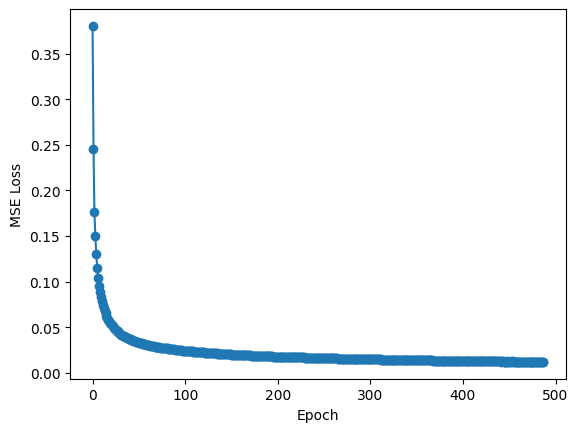

In [20]:
# Plot training loss
plt.figure()
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [21]:
model.eval()
scores, labels = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(DEVICE)
        recon = model(x)
        err = ((x - recon) ** 2)         # shape: [B, 1, 768]
        err = err.view(err.size(0), -1)  # shape: [B, 768]
        err = err.mean(dim=1)            # now shape: [B], 1 scalar per sample
        scores.extend(err.cpu().numpy())
        labels.extend(y)

labels = [int(l) for l in labels]
scores = [float(s) for s in scores]

auc = roc_auc_score(labels, scores)
print('AUC:', auc)



AUC: 0.9432792342904702


In [22]:
print("Unique labels:", set(labels))


Unique labels: {0, 1}


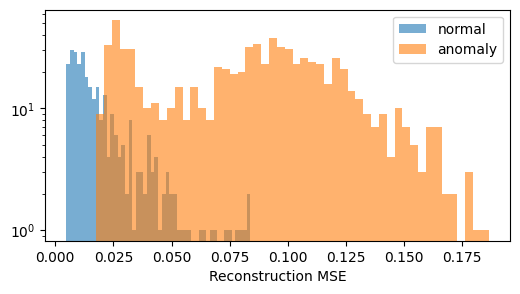

In [23]:
# Error distribution
normal_err = [s for s,l in zip(scores,labels) if l==0]
anom_err   = [s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(normal_err, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom_err,   bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction MSE')
plt.legend()
plt.show()
